In [26]:
import pandas as pd


In [27]:
df = pd.read_csv('/content/drive/MyDrive/Интенсив zero/data_raw.csv')

In [28]:
df2 = pd.read_excel('/content/drive/MyDrive/Интенсив zero/final_results_to_analyze.xlsx')

 Загрузка данных и первичный анализ

In [29]:
print("Размер датасета:", df.shape)
print("\nПропуски в данных:\n", df.isnull().sum())
print("\nКоличество дубликатов:", df.duplicated().sum())


Размер датасета: (27756048, 4)

Пропуски в данных:
 Unnamed: 0    0
client_id     0
dt            0
event_type    0
dtype: int64

Количество дубликатов: 0


In [30]:

print(df.dtypes)

print(df.head())


Unnamed: 0     int64
client_id      int64
dt            object
event_type    object
dtype: object
   Unnamed: 0  client_id          dt event_type
0           0    6095092  2024-06-20     clicks
1           1  541138559  2024-06-18     clicks
2           2   12189072  2024-06-20     clicks
3           3  674385020  2024-06-20     clicks
4           4  726939378  2024-06-20     clicks


Приведение dt к datetime, удаление Unnamed: 0

In [31]:
# Убираем лишний столбец
df = df.drop(columns=["Unnamed: 0"])

# Преобразуем дату в datetime
df["dt"] = pd.to_datetime(df["dt"])

# Проверяем изменения
print(df.dtypes)
print(df.head())


client_id              int64
dt            datetime64[ns]
event_type            object
dtype: object
   client_id         dt event_type
0    6095092 2024-06-20     clicks
1  541138559 2024-06-18     clicks
2   12189072 2024-06-20     clicks
3  674385020 2024-06-20     clicks
4  726939378 2024-06-20     clicks


Преобразование данных к воронке, где на каждую дату для каждого client_id будет указано:

Был ли просмотр магазина (views = 1, если был, 0 – если нет)
Был ли клик на рекламу (clicks = 1, если был, 0 – если нет)
Было ли добавление товара (adds = 1, если было, 0 – если нет)

In [32]:

df_funnel = df.pivot_table(
    index=["client_id", "dt"],
    columns="event_type",
    aggfunc="size",
    fill_value=0
).reset_index()

# Переименуем колонки
df_funnel.columns = ["client_id", "dt", "adds", "clicks", "views"]

# Преобразуем данные: если событие было хотя бы раз, ставим 1
df_funnel[["adds", "clicks", "views"]] = (df_funnel[["adds", "clicks", "views"]] > 0).astype(int)


print(df_funnel.head())


   client_id         dt  adds  clicks  views
0          1 2024-06-17     0       0      1
1          1 2024-06-19     0       0      1
2          3 2024-06-17     0       1      1
3          3 2024-06-18     0       1      1
4          3 2024-06-19     1       1      1


In [8]:
import numpy as np


Ключевые метрики До эксперимента

In [33]:
# Оставляем только тех, у кого были клики
df_funnel_filtered = df_funnel[df_funnel['clicks'] > 0].copy()

# Функция для расчета дисперсии ratio-метрик
def var_ratio(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]
    return var_x / mean_y**2 + var_y * mean_x**2 / mean_y**4 - 2 * mean_x * cov_xy / mean_y**3

# Расчет CTR
mean_ctr = df_funnel_filtered['clicks'].sum() / df_funnel_filtered['views'].sum()
var_ctr = var_ratio(df_funnel_filtered['clicks'], df_funnel_filtered['views'])

# Расчет CR
mean_cr = df_funnel_filtered['adds'].sum() / df_funnel_filtered['clicks'].sum()
var_cr = var_ratio(df_funnel_filtered['adds'], df_funnel_filtered['clicks'])

# Выводим результаты
print(f"Средний CTR: {mean_ctr:.6f}")
print(f"Дисперсия CTR: {var_ctr:.6f}")
print(f"\nСредний CR: {mean_cr:.6f}")
print(f"Дисперсия CR: {var_cr:.6f}")


Средний CTR: 1.027216
Дисперсия CTR: 0.028717

Средний CR: 0.219304
Дисперсия CR: 0.171210


In [10]:
from scipy import stats
import numpy as np
import pandas as pd

# Функция расчета MDE
def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    """Возвращает MDE для метрики при заданных параметрах теста."""
    t_alpha = stats.norm.ppf(1 - ((alpha / 2)), loc=0, scale=1)
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_ratio_correction = r + 2 + 1 / r
    mde = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(sample_size * (1 - target_share * (comparisons - 1)))
    return mde, mde * 100 / mu

# Размеры выборки
sample_sizes = [50_000, 100_000, 200_000, 500_000, 1_000_000]

# Расчет MDE для CR
mde_results = []
for size in sample_sizes:
    mde_abs, mde_percent = get_MDE(mu=mean_cr, std=np.sqrt(var_cr), sample_size=size)
    mde_results.append([size, mde_abs, mde_percent])

# Создаем DataFrame с результатами
df_mde = pd.DataFrame(mde_results, columns=["Размер выборки", "MDE (абс.)", "MDE (%)"])
print(df_mde)


   Размер выборки  MDE (абс.)   MDE (%)
0           50000    0.010368  4.727889
1          100000    0.007332  3.343122
2          200000    0.005184  2.363944
3          500000    0.003279  1.495090
4         1000000    0.002318  1.057188


In [34]:
# общее количество уникальных пользователей
total_users = df["client_id"].nunique()
max_users_for_test = int(total_users * 0.2)  # 20% от общего числа

print(f"Общее количество уникальных пользователей: {total_users}")
print(f"Максимальное количество пользователей для теста и контроля: {max_users_for_test}")


Общее количество уникальных пользователей: 3102736
Максимальное количество пользователей для теста и контроля: 620547


 Оставл. только те размеры выборки, которые меньше лимита

In [35]:

df_mde_filtered = df_mde[df_mde["Размер выборки"] <= max_users_for_test].copy()

print("Обновленная таблица MDE:")
print(df_mde_filtered)


Обновленная таблица MDE:
   Размер выборки  MDE (абс.)   MDE (%)
0           50000    0.010368  4.727889
1          100000    0.007332  3.343122
2          200000    0.005184  2.363944
3          500000    0.003279  1.495090


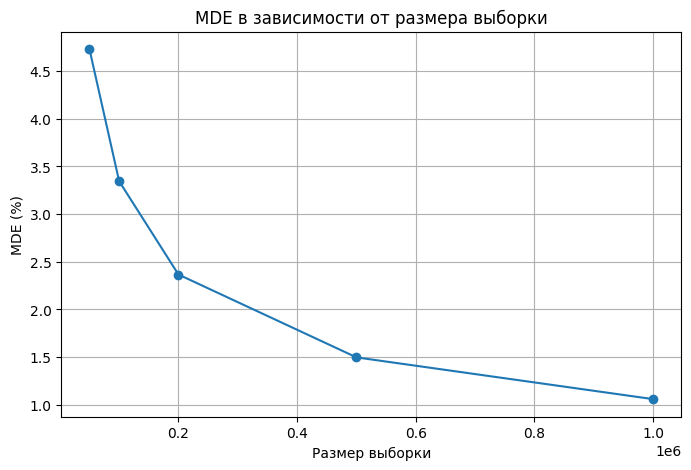

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(df_mde["Размер выборки"], df_mde["MDE (%)"], marker='o', linestyle='-')
plt.xlabel("Размер выборки")
plt.ylabel("MDE (%)")
plt.title("MDE в зависимости от размера выборки")
plt.grid(True)
plt.show()


Вторая часть теста

In [14]:
# Проверяем размер датасета
print("Размер датасета:", df2.shape)

# Выводим типы данных
print("\nТипы данных:\n", df2.dtypes)

# Проверяем пропущенные значения
print("\nПропуски в данных:\n", df2.isnull().sum())

# Проверяем количество дубликатов
print("\nКоличество дубликатов:", df2.duplicated().sum())

# Выводим первые строки
print("\nПервые 5 строк:\n", df2.head())


Размер датасета: (981510, 11)

Типы данных:
 date              datetime64[ns]
client_id                  int64
ab_group                  object
is_view_ads                int64
cnt_view_ads               int64
is_adds_ads                int64
cnt_adds_ads               int64
sum_adds_ads               int64
is_orders_ads              int64
cnt_orders_ads             int64
sum_orders_ads             int64
dtype: object

Пропуски в данных:
 date              0
client_id         0
ab_group          0
is_view_ads       0
cnt_view_ads      0
is_adds_ads       0
cnt_adds_ads      0
sum_adds_ads      0
is_orders_ads     0
cnt_orders_ads    0
sum_orders_ads    0
dtype: int64

Количество дубликатов: 6486

Первые 5 строк:
         date  client_id ab_group  is_view_ads  cnt_view_ads  is_adds_ads  \
0 2024-07-26    8881380     test            0             0            0   
1 2024-07-28  850950385     test            0             0            0   
2 2024-07-25      50885  control            0    

Проверка на дубликаты

In [15]:
print(f"Полные дубликаты: {df2.duplicated().sum()}")


Полные дубликаты: 6486


Проверка есть ли пользователи в обеих группах

In [16]:
# Считаем, сколько раз каждый client_id встречается с разными значениями ab_group
user_groups = df2.groupby("client_id")["ab_group"].nunique()

# Находим тех, кто встречается в обеих группах
multi_group_users = user_groups[user_groups > 1].index

print(f"Пользователей, попавших в обе группы: {len(multi_group_users)}")


Пользователей, попавших в обе группы: 6393


удаление полных дубликатов

In [17]:
df2 = df2.drop_duplicates().copy()
print(f"После удаления дубликатов размер df2: {df2.shape}")


После удаления дубликатов размер df2: (975024, 11)


удаление попавших в обе группы

In [18]:
df2 = df2[~df2["client_id"].isin(multi_group_users)].copy()
print(f"После удаления пользователей из обеих групп размер df2: {df2.shape}")


После удаления пользователей из обеих групп размер df2: (940417, 11)


In [19]:
# Группируем данные по группам и считаем метрики
metrics_clean = df2.groupby('ab_group').agg(
    total_revenue=('sum_orders_ads', 'sum'),   # Суммарная выручка
    total_users=('client_id', 'nunique'),      # Число уникальных пользователей
    arpu=('sum_orders_ads', 'mean'),           # Средний доход на пользователя (ARPU)
    ctr=('is_adds_ads', 'mean'),               # CTR (доля пользователей, взаимодействовавших с рекламой)
    cr_adds=('is_adds_ads', 'mean'),           # CR в добавление товаров
    cr_orders=('is_orders_ads', 'mean')        # CR в заказы
).reset_index()

# Выводим пересчитанные метрики
print(metrics_clean)


  ab_group  total_revenue  total_users      arpu       ctr   cr_adds  \
0  control        1565756       194393  3.335235  0.014564  0.014564   
1     test        1666543       194081  3.538623  0.014589  0.014589   

   cr_orders  
0   0.012749  
1   0.012931  


Проверка статистической значимости изменений




In [20]:
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

# T-тест для ARPU
stat_arpu, pval_arpu = ttest_ind(
    df2[df2["ab_group"] == "test"]["sum_orders_ads"],
    df2[df2["ab_group"] == "control"]["sum_orders_ads"],
    equal_var=False
)
print(f"ARPU: t-stat={stat_arpu:.4f}, p-value={pval_arpu:.4f}")

# Z-тест для CR Adds и CR Orders
for metric in ["is_adds_ads", "is_orders_ads"]:
    count_test = df2[df2["ab_group"] == "test"][metric].sum()
    count_control = df2[df2["ab_group"] == "control"][metric].sum()
    nobs_test = df2[df2["ab_group"] == "test"].shape[0]
    nobs_control = df2[df2["ab_group"] == "control"].shape[0]

    stat, pval = proportions_ztest([count_test, count_control], [nobs_test, nobs_control])
    print(f"{metric}: Z-stat={stat:.4f}, p-value={pval:.4f}")


ARPU: t-stat=2.1231, p-value=0.0337
is_adds_ads: Z-stat=0.1045, p-value=0.9167
is_orders_ads: Z-stat=0.7854, p-value=0.4322


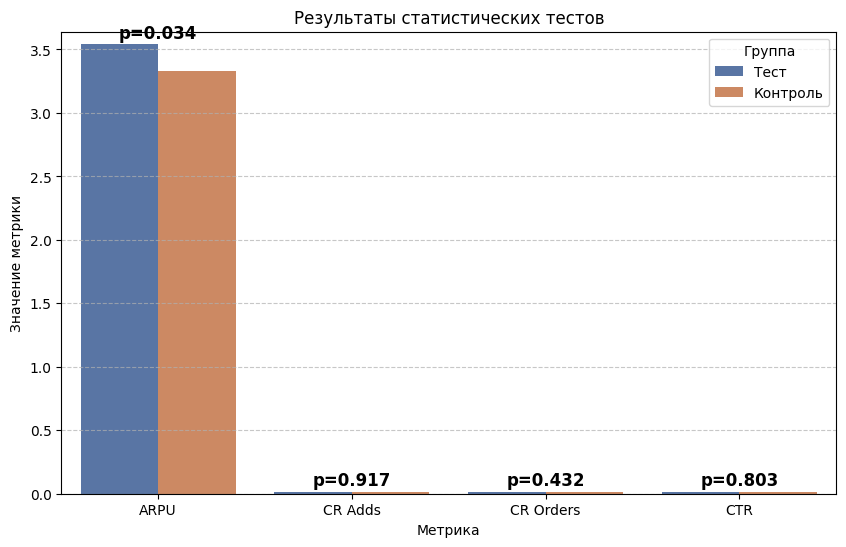

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Данные для графика
metrics_data = {
    "Метрика": ["ARPU", "CR Adds", "CR Orders", "CTR"],
    "Тест": [3.54, 0.0146, 0.0129, 0.0146],  # Значения для тестовой группы
    "Контроль": [3.33, 0.0146, 0.0127, 0.0145],  # Значения для контрольной группы
    "p-value": [0.0337, 0.9167, 0.4322, 0.8034]  # p-values
}

# Создаем DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Преобразуем DataFrame в длинный формат для Seaborn
df_melted = df_metrics.melt(id_vars=["Метрика", "p-value"], var_name="Группа", value_name="Значение")

# Построение графика
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x="Метрика", y="Значение", hue="Группа", palette=["#4c72b0", "#dd8452"])

# Добавляем значения p-value
for index, row in df_metrics.iterrows():
    plt.text(index, max(row["Тест"], row["Контроль"]) + 0.05, f'p={row["p-value"]:.3f}',
             ha='center', fontsize=12, fontweight='bold', color="black")

plt.title("Результаты статистических тестов")
plt.ylabel("Значение метрики")
plt.xlabel("Метрика")
plt.legend(title="Группа")
plt.ylim(0, max(df_melted["Значение"]) + 0.1)
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.show()


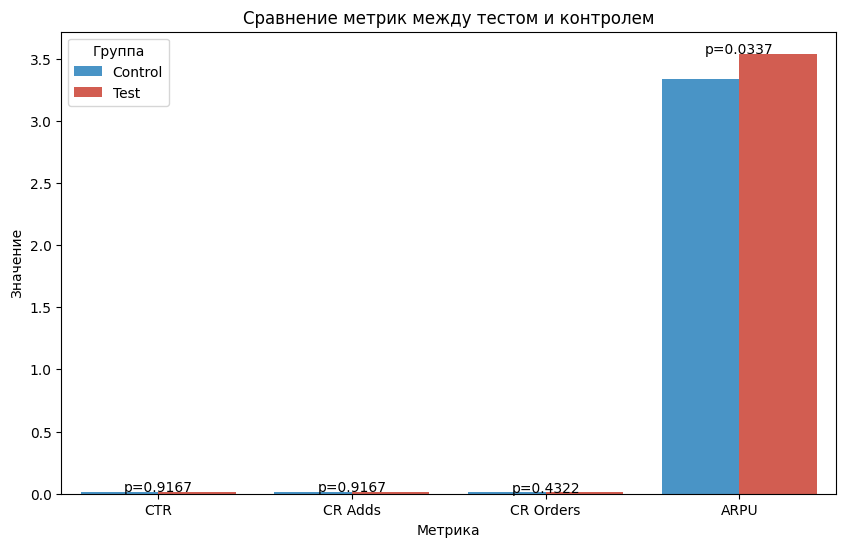

In [38]:


# Данные из тестов
metrics = ["CTR", "CR Adds", "CR Orders", "ARPU"]
control_values = [0.014564, 0.014564, 0.012749, 3.335235]
test_values = [0.014589, 0.014589, 0.012931, 3.538623]
p_values = [0.9167, 0.9167, 0.4322, 0.0337]  # p-values

# Создаем DataFrame
df_stats = pd.DataFrame({"Метрика": metrics, "Control": control_values, "Test": test_values, "p-value": p_values})

# Построение графика
plt.figure(figsize=(10, 6))
df_stats_melted = df_stats.melt(id_vars="Метрика", value_vars=["Control", "Test"], var_name="Группа", value_name="Значение")

sns.barplot(x="Метрика", y="Значение", hue="Группа", data=df_stats_melted, palette=["#3498db", "#e74c3c"])
plt.title("Сравнение метрик между тестом и контролем")
plt.xlabel("Метрика")
plt.ylabel("Значение")
plt.legend(title="Группа")

# Добавляем p-values
for i, p in enumerate(p_values):
    plt.text(i, max(control_values[i], test_values[i]) + 0.0005, f"p={p:.4f}", ha="center", fontsize=10, color="black")

plt.show()


In [23]:
# Группируем данные по группам и рассчитываем дополнительные метрики
extra_metrics = df2.groupby("ab_group").agg(
    avg_check_orders=("sum_orders_ads", lambda x: x.sum() / x.count()),  # Средний чек заказа
    avg_orders_per_user=("cnt_orders_ads", lambda x: x.sum() / df2["client_id"].nunique())  # Среднее число заказов на пользователя
).reset_index()

# Выводим результаты
print(extra_metrics)


  ab_group  avg_check_orders  avg_orders_per_user
0  control          3.335235             0.014145
1     test          3.538623             0.014951


In [24]:
from scipy.stats import ttest_ind

# T-тест для проверки различий
for metric in ["sum_orders_ads", "cnt_orders_ads"]:
    test_group = df2[df2["ab_group"] == "test"][metric]
    control_group = df2[df2["ab_group"] == "control"][metric]

    stat, pval = ttest_ind(test_group, control_group, equal_var=False)
    print(f"{metric}: T-stat = {stat:.4f}, p-value = {pval:.4f}")


sum_orders_ads: T-stat = 2.1231, p-value = 0.0337
cnt_orders_ads: T-stat = 2.1627, p-value = 0.0306
